In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/RA/SAR

/content/gdrive/MyDrive/RA/SAR


# 1. Data
* [Global Airports](https://datacatalog.worldbank.org/search/dataset/0038117/Global-Airports) data from World Bank Data Catalog
  * Location and total seats data of international airports. Total seats in air travel were extracted for 2019 and mapped as straight lines between airports.
  * Columns: Orig, Name, TotalSeats, Country Name, AirportLatitude, AirportLongitude

* In a further application, 'TotalSeats' will be the observable dependent variable (Y).

## 1-1. Observable variable Y

In [ ]:
df = pd.read_csv('./airport_volume_airport_locations.csv')
df.head(5)

,Orig,Name,TotalSeats,Country Name,Airport1Latitude,Airport1Longitude
0,HEA,Herat,22041.971,Afghanistan,34.206902,62.226700
1,JAA,Jalalabad,6343.512,Afghanistan,34.400002,70.500000
2,KBL,Kabul International,1016196.825,Afghanistan,34.563900,69.213898
3,KDH,Kandahar International,39924.262,Afghanistan,31.506901,65.847504
4,MZR,Mazar-e-Sharif,58326.513,Afghanistan,36.704201,67.208298


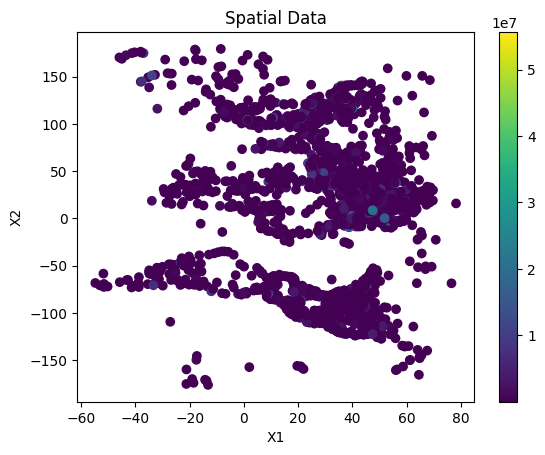

In [ ]:
# Create a DataFrame with coordinate(x1, x2) and y
data = pd.DataFrame({'x1': df['Airport1Latitude'], 'x2': df['Airport1Longitude'], 'y': df['TotalSeats']})

# Plot the data on a scatter plot
plt.scatter(data['x1'], data['x2'], c=data['y'])
plt.colorbar()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Spatial Data')
plt.show()

In [ ]:
# Make the mean of y zero
mean_y = np.mean(data['y'])
std_y = np.std(data['y'])
data['std_y'] = (data['y'] - mean_y) / std_y

In [ ]:
print(data)

             x1         x2            y     std_y
0     34.206902  62.226700    22041.971 -0.267049
1     34.400002  70.500000     6343.512 -0.270893
2     34.563900  69.213898  1016196.825 -0.023638
3     31.506901  65.847504    39924.262 -0.262671
4     36.704201  67.208298    58326.513 -0.258165
...         ...        ...          ...       ...
2168 -13.259400  31.934799      589.288 -0.272301
2169 -12.995800  28.663099   101855.831 -0.247507
2170 -20.016899  28.618099   100997.897 -0.247717
2171 -17.922800  31.101400   751216.543 -0.088516
2172 -18.093100  25.840300   229726.994 -0.216199

[2173 rows x 4 columns]


## 1-2. Weight Matrix

In [ ]:
# Create coordinates array
coordinates = np.hstack((data['x1'].values.reshape(-1, 1), data['x2'].values.reshape(-1, 1)))

print(coordinates)

[[ 34.20690155  62.22669983]
 [ 34.40000153  70.5       ]
 [ 34.56389999  69.21389771]
 ...
 [-20.01689911  28.61809921]
 [-17.92280006  31.10140038]
 [-18.09309959  25.84029961]]


In [ ]:
# Initialize an empty distances matrix
n = len(coordinates)
distances = np.zeros((n, n))

# Compute the euclidean distance between pair of coordinates
for i in range(n):
    for j in range(i+1, n):
        distances[i,j] = distances[j,i] = np.linalg.norm(coordinates[i] - coordinates[j])       

print(distances)

[[ 0.          8.27555335  6.99631204 ... 63.7946596  60.71482567
  63.71232408]
 [ 8.27555335  0.          1.29650369 ... 68.66798882 65.4975207
  68.92034898]
 [ 6.99631204  1.29650369  0.         ... 68.02266156 64.86459847
  68.22044134]
 ...
 [63.7946596  68.66798882 68.02266156 ...  0.          3.24838968
   3.37893108]
 [60.71482567 65.4975207  64.86459847 ...  3.24838968  0.
   5.26385631]
 [63.71232408 68.92034898 68.22044134 ...  3.37893108  5.26385631
   0.        ]]


In [ ]:
print('Mean: ', np.mean(distances))
print('Median: ', np.median(distances))
print('Max: ', np.max(distances))
print('25%: ', np.percentile(distances, 25))
print('75%: ', np.percentile(distances, 75))

Mean:  96.03310928413694
Median:  90.44421005448457
Max:  356.8335407179159
25%:  45.69468084631447
75%:  130.2191506944656


In [ ]:
threshold = np.median(distances) 
print(threshold)

90.44421005448457


In [ ]:
# Make a weight matrix using threshold
n = len(distances)
weights = np.zeros((n, n))

threshold = np.mean(distances)

for i in range(n):
  for j in range(i+1, n):
    if distances[i, j] <= threshold:
      weights[i, j] = weights[j, i] = 1

# Normalize
sum_row = weights.sum(axis=1, keepdims=True)
normalized_weights = weights / sum_row

print(normalized_weights)

[[0.         0.00069156 0.00069156 ... 0.00069156 0.00069156 0.00069156]
 [0.00069061 0.         0.00069061 ... 0.00069061 0.00069061 0.00069061]
 [0.00068918 0.00068918 0.         ... 0.00068918 0.00068918 0.00068918]
 ...
 [0.00075873 0.00075873 0.00075873 ... 0.         0.00075873 0.00075873]
 [0.00075643 0.00075643 0.00075643 ... 0.00075643 0.         0.00075643]
 [0.0007485  0.0007485  0.0007485  ... 0.0007485  0.0007485  0.        ]]


# 2. Simulation model
* Generate random variable $v$ from standard normal distribution
* Calculate $y = Wv$, make a list of generated $y$




## 2-1. Generate $y$


In [ ]:
# Set up parameters
num_simulations = 1000
num_points = len(data)
w = normalized_weights

results = []

# Run simulations
for i in range(num_simulations):
    # Generate random v from standard normal distribution
    v = np.random.normal(size=num_points)  
    # Calculate y = wv
    y = np.dot(w, v)
    results.append(y)

# Make a column names list; y1, y2, ..
col_names = []

for i in range(num_points):
    col_names.append('y{}'.format(i+1))

# Convert results to dataframe
simul_df = pd.DataFrame(results, columns=col_names)

print(simul_df)

           y1        y2        y3        y4        y5        y6        y7  \
0    0.001703 -0.003262 -0.004174 -0.002200 -0.001535 -0.003334  0.000319   
1   -0.076064 -0.080924 -0.079782 -0.078420 -0.078227 -0.079638 -0.075807   
2    0.005895  0.004969  0.004935  0.004123  0.005465  0.004938  0.004711   
3    0.024023  0.020256  0.019382  0.021423  0.021355  0.019030  0.021092   
4    0.009653  0.010192  0.008429  0.008377  0.009403  0.008210  0.009260   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.007005 -0.004463 -0.002717 -0.004461 -0.007430 -0.003650 -0.007354   
996 -0.013731 -0.014097 -0.014264 -0.015098 -0.013919 -0.013928 -0.015254   
997  0.001397  0.000100  0.000629  0.000372  0.000456  0.000425 -0.000036   
998 -0.049822 -0.049205 -0.049468 -0.049029 -0.049791 -0.048606 -0.049800   
999 -0.010150 -0.009572 -0.009511 -0.009247 -0.008497 -0.010002 -0.010860   

           y8        y9       y10  ...     y2164     y2165     y2166  \
0  

## 2-2. Compare Covariance

* Covariance of generated $y$ pairs


In [ ]:
# Calculate covariance matrix of generated y
simul_cov_matrix = np.cov(simul_df)

# Covert it into dataframe
simul_cov_df = pd.DataFrame(data=simul_cov_matrix, index=col_names, columns=col_names)
simul_cov_series = simul_cov_df.stack()

# Rename columns
simul_cov_df = pd.DataFrame(simul_cov_series, columns=['Covariance'])

print(simul_cov_df.head(10))

ValueError: ignored

In [ ]:
# Rename index
index_names = []
y_num = len(data['y'])

for i in range(1,y_num+1):
  for j in range(1,y_num+1):
    index_names.append("(y{}, y{})".format(i, j))

simul_cov_df.index = index_names

print(simul_cov_df.head())